# Examen práctico 
## Parcial 1 Laboratorio de Aprendizaje Estadístico
Diego Lozoya Morales | 745345

# Paqueterías

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from scipy import stats
import statsmodels.formula.api as smf
from sklearn.neighbors import KNeighborsRegressor
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

colors = ["cornflowerblue", "indianred", "darkseagreen", "plum", "dimgray"]

# Funciones

In [106]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False)+1
    grouped = df_calibracion.groupby('bins').mean()

    plt.figure(figsize=(10, 5))
    plt.plot(grouped.predicciones, grouped.y, label="Modelo", marker="o", color=colors[0])
    plt.plot(grouped.predicciones, grouped.predicciones, label="Real", marker="o", color=colors[1])
    plt.xlabel("Prediccion")
    plt.ylabel("Real")
    plt.title("Calibración")
    plt.grid()
    plt.legend()
    plt.show()

def vibariado(df, y):
    target = y.name
    num_vars = len(df.keys().drop(target))
    num_rows = (num_vars + 1) // 2 
    
    fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))
    axes = axes.flatten()
    
    for idx, i in enumerate(df.keys().drop(target)):
        X = df[[i]]
        model = linear_model.LinearRegression().fit(X, y)
        
        q = len(X.iloc[:, 0].unique()) if len(X.iloc[:, 0].unique()) < 5 else 10
        df[i + "_bin"] = pd.qcut(df[i], q=q, labels=False, duplicates="drop") + 1
        grouped = df.groupby(i + "_bin").mean()
        
        ax = axes[idx]
        ax.plot(grouped[i].values, grouped[target].values, color=colors[0], marker='o')
        ax.set_xlabel(f"{i} bins")
        ax.set_ylabel(target)
        ax.set_title(f"Análisis bivariado entre {i} y {target}")
        ax.grid()
        
        df.drop(columns=[i + "_bin"], inplace=True)
    
    plt.tight_layout()
    plt.show()

def comparacion(modelos, y):
     plt.figure(figsize=(10, 5))

     for i, modelo in enumerate(modelos):
          col_pred = f'predicciones_{modelo}'

          df_calibracion = pd.DataFrame({
               'predicciones': globals()[col_pred],
               'y': y
          })

          df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=10, labels=False)+1
          grouped = df_calibracion.groupby('bins').mean()
          plt.plot(grouped['predicciones'].values, grouped['y'].values, marker='o', color=colors[i], label=modelos[i])

     plt.plot(grouped['predicciones'].values, grouped['predicciones'].values, color=colors[-1], linestyle="--", label="Real", zorder=100)
     plt.xlabel("Valores predichos")
     plt.ylabel("Valores reales")
     plt.title("Comparación de modelos")
     plt.grid()
     plt.legend()
     plt.show()

def graficas_KNN(resultados, nn_opt):
     fig, axes = plt.subplots(1, 2, figsize=(15, 5))  

     axes[0].plot(resultados.nn, resultados.r2, label='real', color=colors[0], marker='o')
     axes[0].grid()
     axes[0].set_title("$R^2$ Real")
     axes[0].set_xlabel("Nearest Neighbors")
     axes[0].set_ylabel("$R^2$")

     axes[1].plot(resultados.nn, resultados.r2_train, label='train', color=colors[1], marker='o')
     axes[1].grid()
     axes[1].set_title("$R^2$ Train")
     axes[1].set_xlabel("Nearest Neighbors")
     axes[1].set_ylabel("$R^2$")

     plt.show()

     plt.figure(figsize=(15, 5))
     plt.plot(resultados.nn, resultados.r2, label='Real', color=colors[0], marker='o')
     plt.plot(resultados.nn, resultados.r2_train, label='Train', color=colors[1], marker='o')
     plt.scatter(nn_opt, max(resultados.r2), label=f'Óptimo nn = {nn_opt}', color=colors[2], s=50, zorder=3)
     plt.text(nn_opt, max(resultados.r2)-0.05, f"Máximo $R^2$", va='bottom')
     plt.grid()
     plt.legend()
     plt.title("$R^2$ Real vs Train")
     plt.xlabel("Nearest Neighbors")
     plt.ylabel("$R^2$")
     plt.show()

def AB_test(test, control):
    # Mu
    mu_test = test.mean()
    mu_control = control.mean()

    # SE
    se_test = test.sem()
    se_control = control.sem()

    # Differences
    mu_diff = mu_control - mu_test
    se_diff = np.sqrt((test.var() / len(test) + (control.var() / len(control))))

    # Z score and p value 
    z = mu_diff / se_diff

    p_value = stats.norm.cdf(z)

    print(f"Intervalo variable test: ({mu_test - 2*se_test:,.4f}, {mu_test + 2*se_test:,.4f})")
    print(f"Intervalo variable control: ({mu_control - 2*se_control:,.4f}, {mu_control + 2*se_control:,.4f})")
    print(f'Intervalo de confianza del efecto causal: ({mu_diff - 2*se_diff:,.4f}, {mu_diff + 2*se_diff:,.4f})')
    print(f"Z score {z:,.4f}")
    print(f"P-value {p_value:,.4f}")

# Data

In [107]:
data = pd.read_csv("Data/Boston.csv")
data.head()

,Unnamed: 0,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


## Explicación variables Dataset

CRIM - per capita crime rate by town

ZN - proportion of residential land zoned for lots over 25,000 sq.ft.

INDUS - proportion of non-retail business acres per town.

CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)

NOX - nitric oxides concentration (parts per 10 million)

RM - average number of rooms per dwelling

AGE - proportion of owner-occupied units built prior to 1940

DIS - weighted distances to five Boston employment centres

RAD - index of accessibility to radial highways

TAX - full-value property-tax rate per $10,000

PTRATIO - pupil-teacher ratio by town

LSTAT - % lower status of the population

MEDV - Median value of owner-occupied homes in $1000's

## Limpieza de datos

In [108]:
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


## Variable dependiente

In [109]:
target = 'medv'
y = data[target]

# Análisis vibariado Dataset original

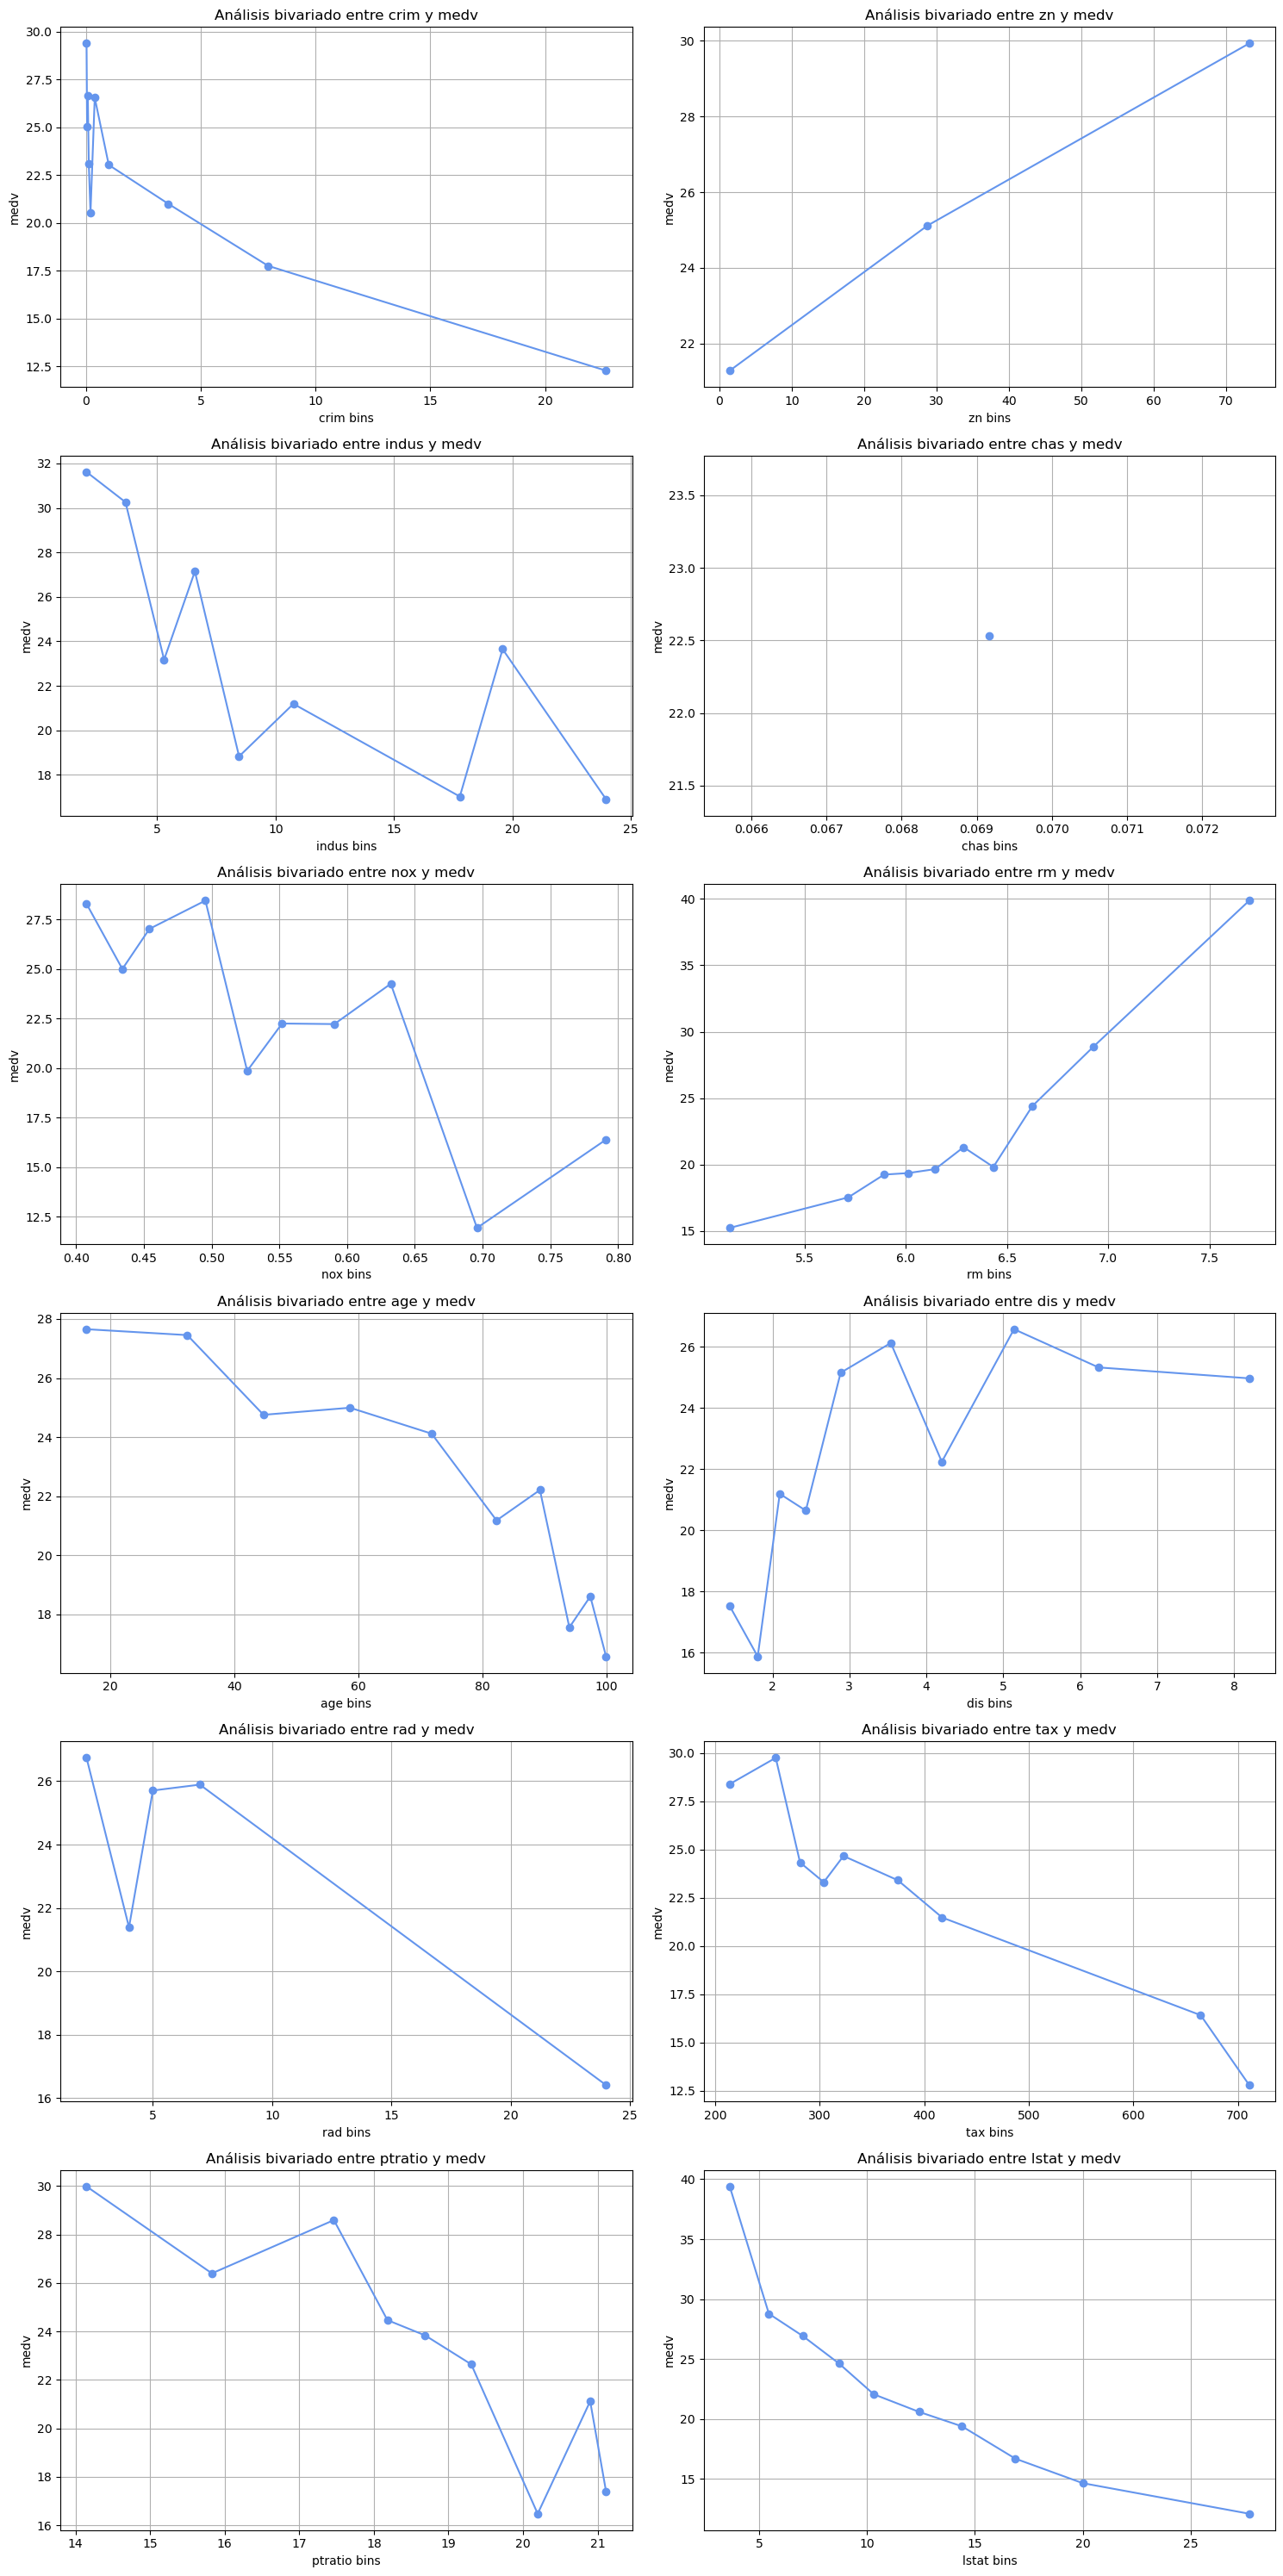

In [110]:
vibariado(data, y)

# Feature engineering

## Dummies

In [111]:
data = pd.get_dummies(data, columns=['rad'])

## Transformaciones

- Logaritmo de la tasa de crimen per capita por ciudad
- Logaritmo de la concentración de óxido nitrico
- Cuadrado de número de cuartos promedio por vivienda
- Raíz de la distancia ponderada de 5 centros de empleo en Boston
- Logaritmo del valor total de la propiedad por la tasa de impuestos por $10,000

In [112]:
data['log_crim'] = np.log(data['crim'])
data['log_nox'] = np.log(data['nox'])
data['rm_2'] = data['rm'] ** 2
data['sqrt_dis'] = np.sqrt(data['dis'])
data['log_tax'] = np.log(data['tax'])

## Análisis vibariado

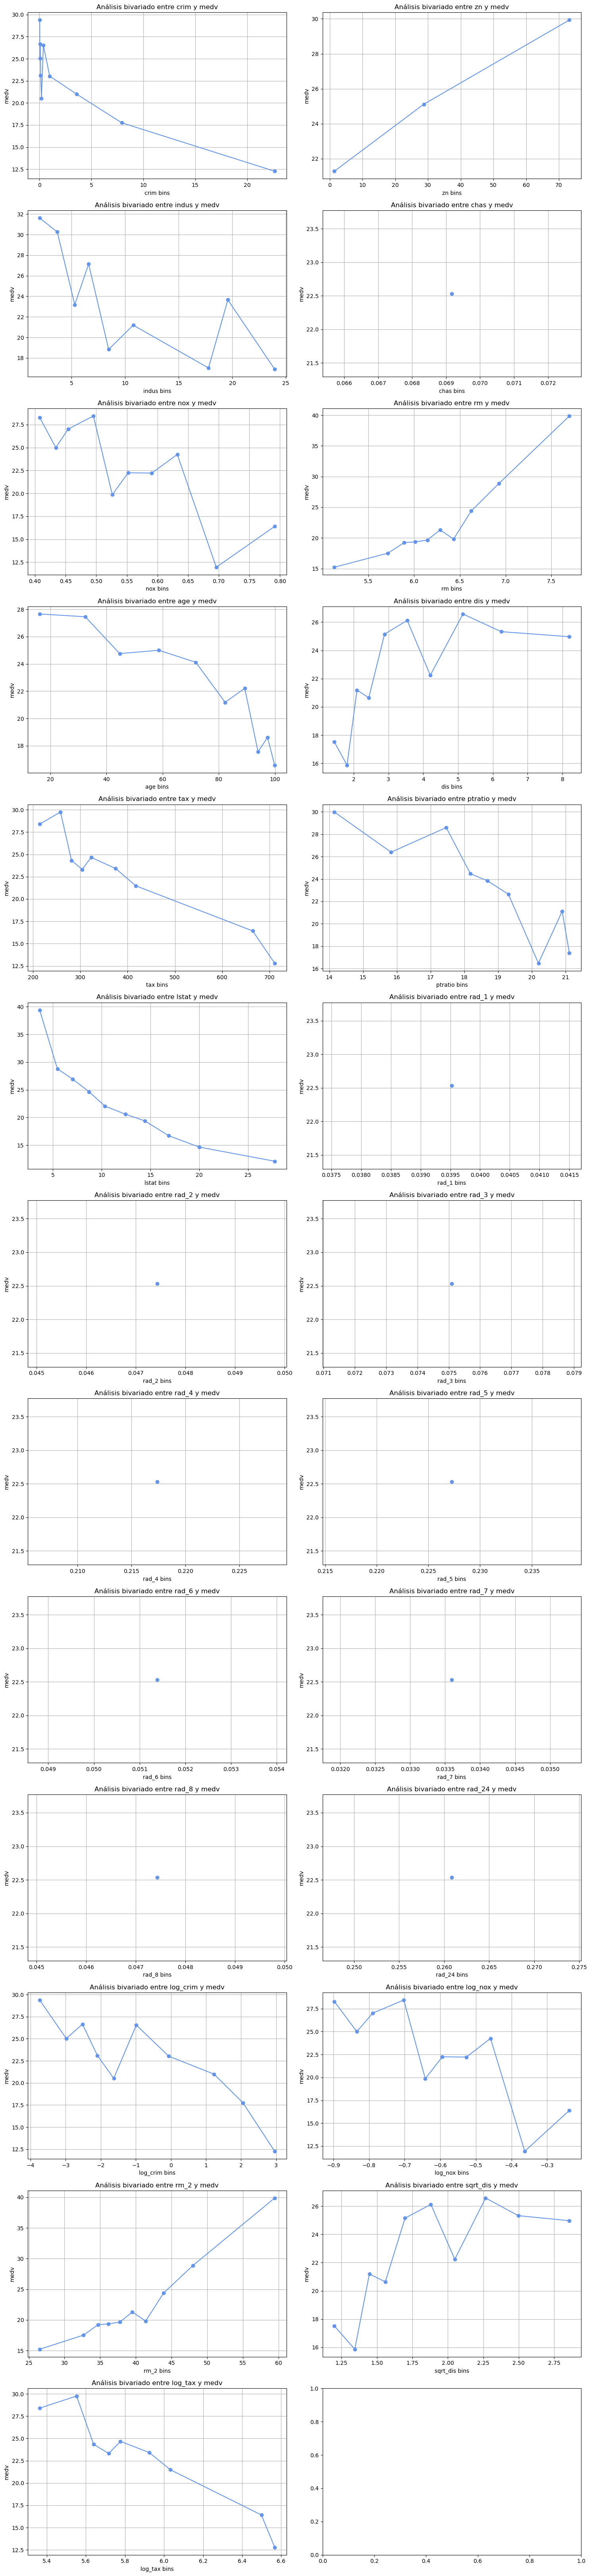

In [113]:
vibariado(data, y)

# Significancia de variables

In [114]:
controls = data.keys().drop(target)

result = smf.ols('medv ~ ' + '+'.join(controls), data=data).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,202.8538,28.007,7.243,0.000,147.823,257.885
rad_1[T.True],19.7497,3.441,5.739,0.000,12.988,26.512
rad_2[T.True],21.0891,3.369,6.260,0.000,14.469,27.709
rad_3[T.True],23.9729,3.174,7.552,0.000,17.736,30.210
rad_4[T.True],22.4667,3.263,6.885,0.000,16.055,28.878
rad_5[T.True],22.6415,3.259,6.948,0.000,16.238,29.045
rad_6[T.True],21.5771,3.364,6.415,0.000,14.968,28.187
rad_7[T.True],23.3521,3.370,6.928,0.000,16.729,29.975
rad_8[T.True],22.7834,3.322,6.859,0.000,16.257,29.310
rad_24[T.True],25.2212,2.703,9.332,0.000,19.910,30.532


In [115]:
controls = controls.drop('indus')
data.drop('indus', axis=1, inplace=True)

result = smf.ols('medv ~ ' + '+'.join(controls), data=data).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,202.4772,27.198,7.445,0.000,149.036,255.918
rad_1[T.True],19.6996,3.325,5.924,0.000,13.166,26.233
rad_2[T.True],21.0324,3.217,6.537,0.000,14.711,27.354
rad_3[T.True],23.9334,3.095,7.732,0.000,17.852,30.015
rad_4[T.True],22.4154,3.135,7.150,0.000,16.256,28.575
rad_5[T.True],22.5958,3.156,7.159,0.000,16.394,28.798
rad_6[T.True],21.5351,3.279,6.567,0.000,15.092,27.979
rad_7[T.True],23.3071,3.274,7.118,0.000,16.873,29.741
rad_8[T.True],22.7420,3.239,7.022,0.000,16.378,29.106
rad_24[T.True],25.2164,2.699,9.344,0.000,19.914,30.519


In [116]:
controls = controls.drop('tax')
data.drop('tax', axis=1, inplace=True)

result = smf.ols('medv ~ ' + '+'.join(controls), data=data).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,195.7192,20.236,9.672,0.000,155.958,235.480
rad_1[T.True],18.8360,2.380,7.913,0.000,14.159,23.513
rad_2[T.True],20.2340,2.396,8.444,0.000,15.526,24.942
rad_3[T.True],23.2067,2.400,9.669,0.000,18.491,27.923
rad_4[T.True],21.6221,2.297,9.412,0.000,17.108,26.136
rad_5[T.True],21.7625,2.224,9.786,0.000,17.393,26.132
rad_6[T.True],20.6758,2.327,8.883,0.000,16.103,25.249
rad_7[T.True],22.5096,2.474,9.097,0.000,17.648,27.371
rad_8[T.True],21.9210,2.370,9.249,0.000,17.264,26.578
rad_24[T.True],24.9514,2.601,9.594,0.000,19.841,30.062


In [117]:
controls = controls.drop('log_crim')
data.drop('log_crim', axis=1, inplace=True)

result = smf.ols('medv ~ ' + '+'.join(controls), data=data).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,197.0332,20.169,9.769,0.000,157.403,236.663
rad_1[T.True],18.7206,2.376,7.880,0.000,14.053,23.388
rad_2[T.True],20.1982,2.395,8.433,0.000,15.492,24.904
rad_3[T.True],23.2763,2.398,9.707,0.000,18.565,27.988
rad_4[T.True],21.8117,2.285,9.544,0.000,17.321,26.302
rad_5[T.True],21.8536,2.220,9.842,0.000,17.491,26.217
rad_6[T.True],20.7109,2.326,8.903,0.000,16.140,25.282
rad_7[T.True],22.7264,2.460,9.238,0.000,17.893,27.560
rad_8[T.True],22.1936,2.347,9.456,0.000,17.582,26.805
rad_24[T.True],25.5420,2.503,10.203,0.000,20.623,30.461


In [118]:
controls = controls.drop('age')
data.drop('age', axis=1, inplace=True)

result = smf.ols('medv ~ ' + '+'.join(controls), data=data).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,186.3489,19.236,9.688,0.000,148.553,224.145
rad_1[T.True],17.5216,2.277,7.697,0.000,13.048,21.995
rad_2[T.True],18.8618,2.271,8.305,0.000,14.399,23.324
rad_3[T.True],22.0288,2.291,9.615,0.000,17.527,26.531
rad_4[T.True],20.6316,2.185,9.441,0.000,16.338,24.925
rad_5[T.True],20.6673,2.116,9.768,0.000,16.510,24.825
rad_6[T.True],19.6323,2.246,8.743,0.000,15.220,24.045
rad_7[T.True],21.5816,2.374,9.091,0.000,16.917,26.246
rad_8[T.True],20.8702,2.223,9.388,0.000,16.502,25.238
rad_24[T.True],24.5537,2.442,10.054,0.000,19.755,29.352


In [119]:
controls = controls.drop('log_nox')
data.drop('log_nox', axis=1, inplace=True)

result = smf.ols('medv ~ ' + '+'.join(controls), data=data).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,160.2370,10.109,15.851,0.000,140.375,180.099
rad_1[T.True],14.6207,1.371,10.666,0.000,11.927,17.314
rad_2[T.True],15.8293,1.244,12.728,0.000,13.386,18.273
rad_3[T.True],18.8802,1.164,16.220,0.000,16.593,21.167
rad_4[T.True],17.7529,1.233,14.392,0.000,15.329,20.177
rad_5[T.True],17.8687,1.184,15.097,0.000,15.543,20.194
rad_6[T.True],16.8408,1.409,11.956,0.000,14.073,19.608
rad_7[T.True],18.5450,1.420,13.062,0.000,15.755,21.335
rad_8[T.True],18.0212,1.325,13.604,0.000,15.418,20.624
rad_24[T.True],21.8781,1.777,12.311,0.000,18.386,25.370


In [120]:
controls = controls.drop('zn')
data.drop('zn', axis=1, inplace=True)

result = smf.ols('medv ~ ' + '+'.join(controls), data=data).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,162.7859,9.956,16.351,0.000,143.224,182.347
rad_1[T.True],15.0449,1.339,11.238,0.000,12.414,17.675
rad_2[T.True],16.1364,1.226,13.166,0.000,13.728,18.545
rad_3[T.True],19.1008,1.155,16.542,0.000,16.832,21.369
rad_4[T.True],18.1315,1.205,15.045,0.000,15.764,20.499
rad_5[T.True],18.0820,1.175,15.388,0.000,15.773,20.391
rad_6[T.True],17.1273,1.395,12.275,0.000,14.386,19.869
rad_7[T.True],18.7314,1.415,13.238,0.000,15.951,21.512
rad_8[T.True],18.1046,1.325,13.667,0.000,15.502,20.707
rad_24[T.True],22.3270,1.750,12.757,0.000,18.888,25.766


# Preparación de datos

## Cross validation

In [121]:
X = data.copy().drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Scaler

In [122]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Regresión lineal múltiple

## Modelo normal

In [123]:
model = linear_model.LinearRegression().fit(X_train_scaled, y_train)
predicciones_RLM = model.predict(X_test_scaled)

r2 = r2_score(y_true=y_test, y_pred=predicciones_RLM)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_RLM)
print(f"MSE: {mse:,.4f}")

coeficientes = pd.DataFrame({
     'names': X.keys(),
     'coeficientes': model.coef_
})

print()
print(f"Intercepto del modelo: {model.intercept_:,.2f}\nCoeficientes del modelo:")
display(coeficientes)

R² Score: 0.8219
MSE: 13.2702

Intercepto del modelo: 23.02
Coeficientes del modelo:


,names,coeficientes
0,crim,-1.703304
1,chas,0.708828
2,nox,-2.858899
3,rm,-17.616758
4,dis,7.558060
5,ptratio,-1.830872
6,lstat,-4.453218
7,rad_1,-0.730909
8,rad_2,-0.511698
9,rad_3,0.206837


### Calibración

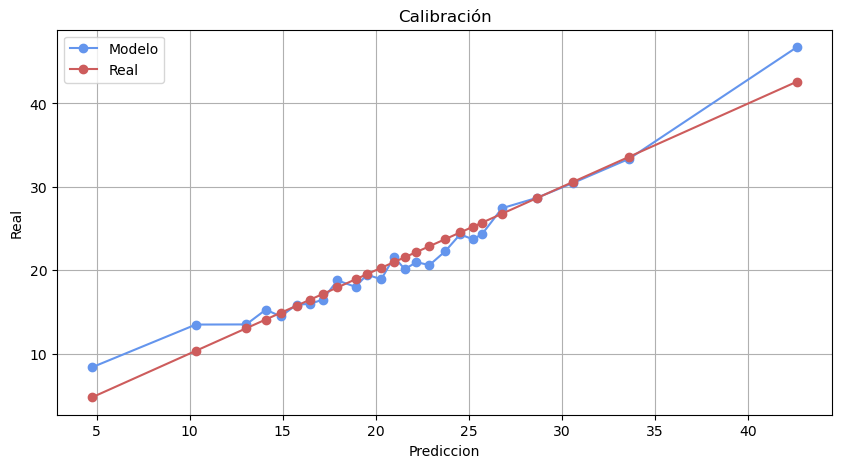

In [124]:
calibracion(predicciones_RLM, y_test, 25)

## Regularización Ridge

In [125]:
model = linear_model.Ridge().fit(X_train_scaled, y_train)
predicciones_RLM_ridge = model.predict(X_test_scaled)

r2 = r2_score(y_true=y_test, y_pred=predicciones_RLM_ridge)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_RLM_ridge)
print(f"MSE: {mse:,.4f}")

coeficientes = pd.DataFrame({
     'names': X.keys(),
     'coeficientes': model.coef_
})

print()
print(f"Intercepto del modelo: {model.intercept_:,.2f}\nCoeficientes del modelo:")
display(coeficientes)

R² Score: 0.8047
MSE: 14.5529

Intercepto del modelo: 23.02
Coeficientes del modelo:


,names,coeficientes
0,crim,-1.557112
1,chas,0.758361
2,nox,-2.696478
3,rm,-10.550889
4,dis,5.452287
5,ptratio,-1.979789
6,lstat,-4.307254
7,rad_1,-0.672793
8,rad_2,-0.474860
9,rad_3,0.254502


### Calibración

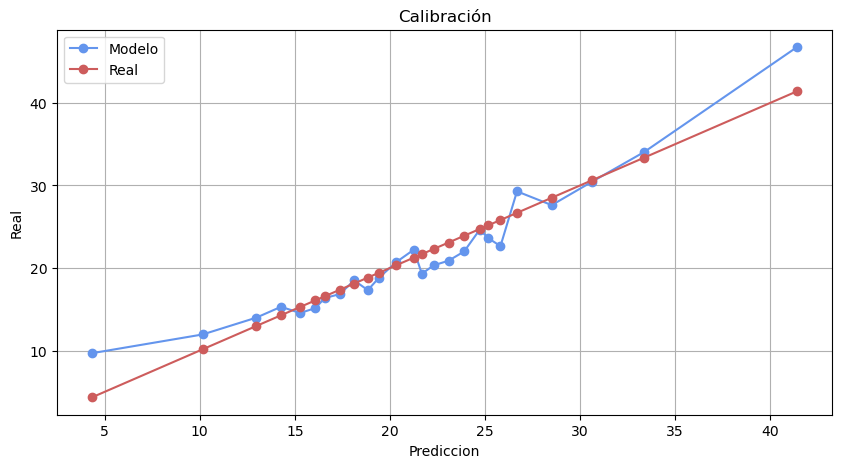

In [126]:
calibracion(predicciones_RLM_ridge, y_test, 25)

## Regularización Lasso

In [127]:
model = linear_model.Lasso().fit(X_train_scaled, y_train)
predicciones_RLM_lasso = model.predict(X_test_scaled)

r2 = r2_score(y_true=y_test, y_pred=predicciones_RLM_lasso)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_RLM_lasso)
print(f"MSE: {mse:,.4f}")

coeficientes = pd.DataFrame({
     'names': X.keys(),
     'coeficientes': model.coef_
})

print()
print(f"Intercepto del modelo: {model.intercept_:,.2f}\nCoeficientes del modelo:")
display(coeficientes)

R² Score: 0.6640
MSE: 25.0362

Intercepto del modelo: 23.02
Coeficientes del modelo:


,names,coeficientes
0,crim,-0.109345
1,chas,0.183187
2,nox,-0.000000
3,rm,0.000000
4,dis,-0.000000
5,ptratio,-1.155314
6,lstat,-3.691758
7,rad_1,-0.000000
8,rad_2,0.000000
9,rad_3,0.000000


### Calibración

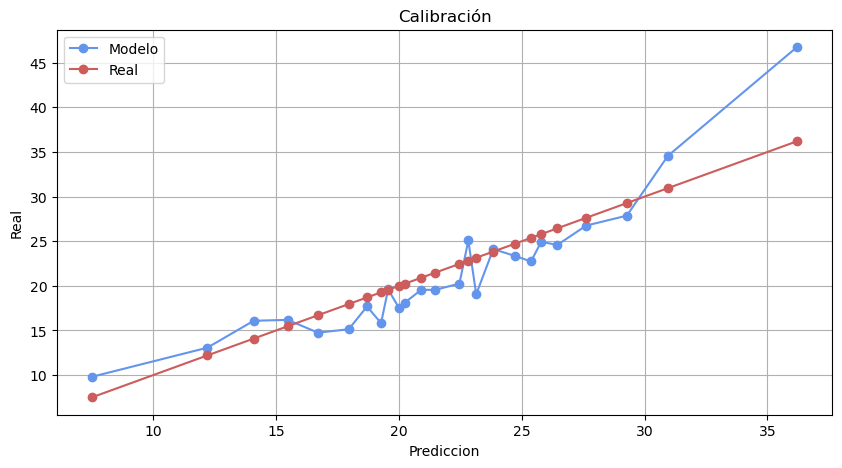

In [128]:
calibracion(predicciones_RLM_lasso, y_test, 25)

## Comparación modelos

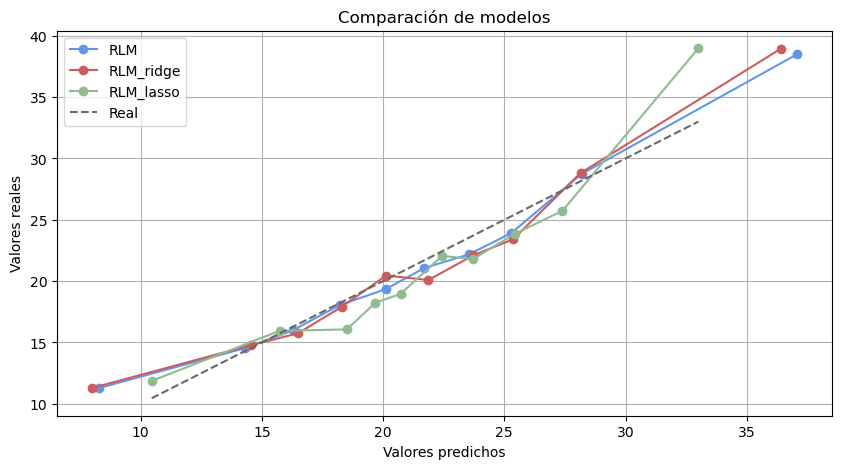

In [129]:
modelos = ['RLM', 'RLM_ridge', 'RLM_lasso']

comparacion(modelos, y_test)

# Regresión polinomial

## Grado 2

In [130]:
degree = 2

poly_features = PolynomialFeatures(degree=degree)
X_poly_train = poly_features.fit_transform(X_train_scaled)
X_poly_test = poly_features.fit_transform(X_test_scaled)

### Modelo Normal

In [131]:
model = linear_model.LinearRegression().fit(X_poly_train, y_train)
predicciones_poly2 = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly2)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly2)
print(f"MSE: {mse:,.4f}")

R² Score: 0.7572
MSE: 18.0883


#### Calibración

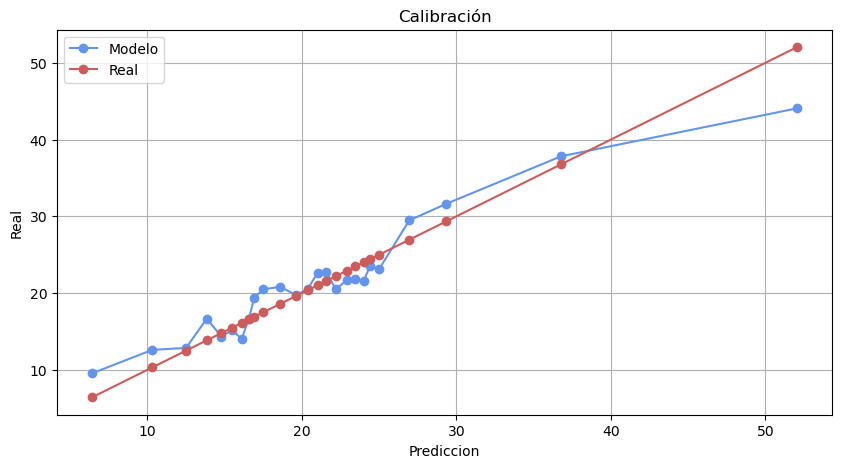

In [132]:
calibracion(predicciones_poly2, y_test, 25)

### Regularización Ridge

In [133]:
model = linear_model.Ridge().fit(X_poly_train, y_train)
predicciones_poly2_ridge = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly2_ridge)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly2_ridge)
print(f"MSE: {mse:,.4f}")

R² Score: 0.8306
MSE: 12.6249


#### Calibración

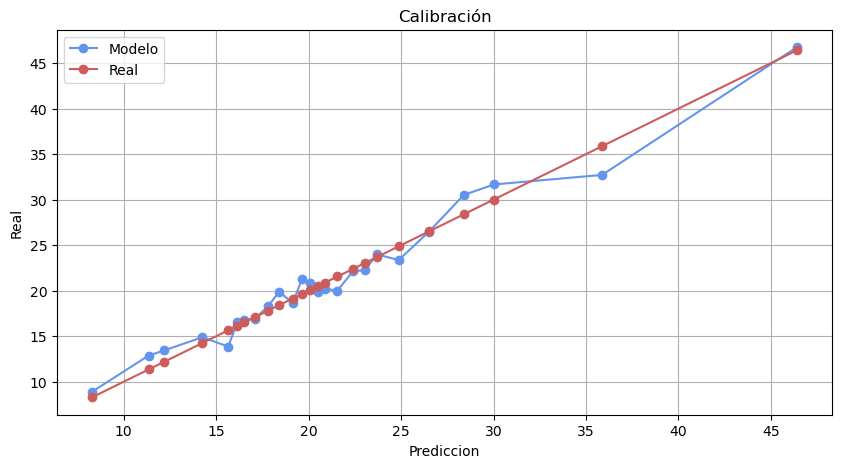

In [134]:
calibracion(predicciones_poly2_ridge, y_test, 25)

### Regularización Lasso

In [135]:
model = linear_model.Lasso().fit(X_poly_train, y_train)
predicciones_poly2_lasso = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly2_lasso)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly2_lasso)
print(f"MSE: {mse:,.4f}")

R² Score: 0.7528
MSE: 18.4226


#### Calibración

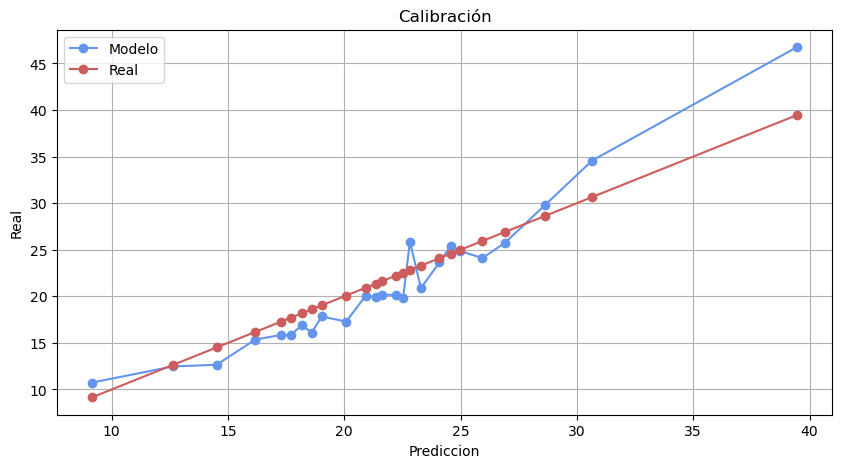

In [136]:
calibracion(predicciones_poly2_lasso, y_test, 25)

## Comparación modelos

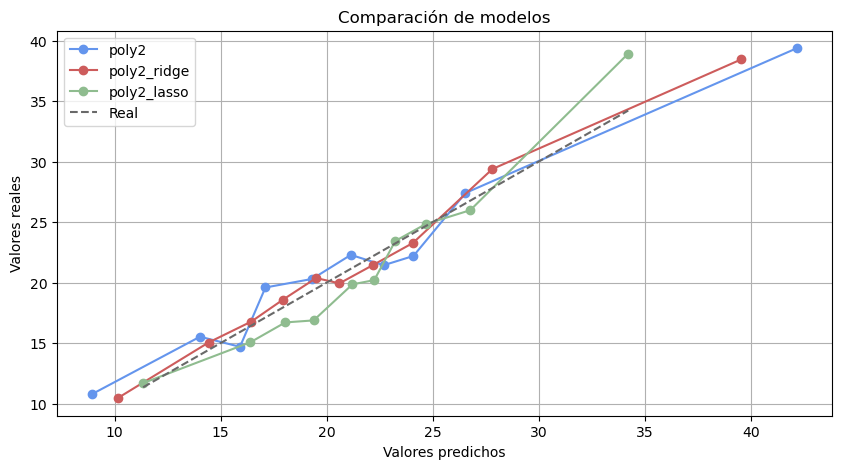

In [137]:
modelos = ['poly2', 'poly2_ridge', 'poly2_lasso']

comparacion(modelos, y_test)

## Grado 3

In [138]:
degree = 3

poly_features = PolynomialFeatures(degree=degree)
X_poly_train = poly_features.fit_transform(X_train_scaled)
X_poly_test = poly_features.fit_transform(X_test_scaled)

### Modelo Normal

In [139]:
model = linear_model.LinearRegression().fit(X_poly_train, y_train)
predicciones_poly3 = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly3)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly3)
print(f"MSE: {mse:,.4f}")

R² Score: -6,167.8021
MSE: 459,656.5424


#### Calibración

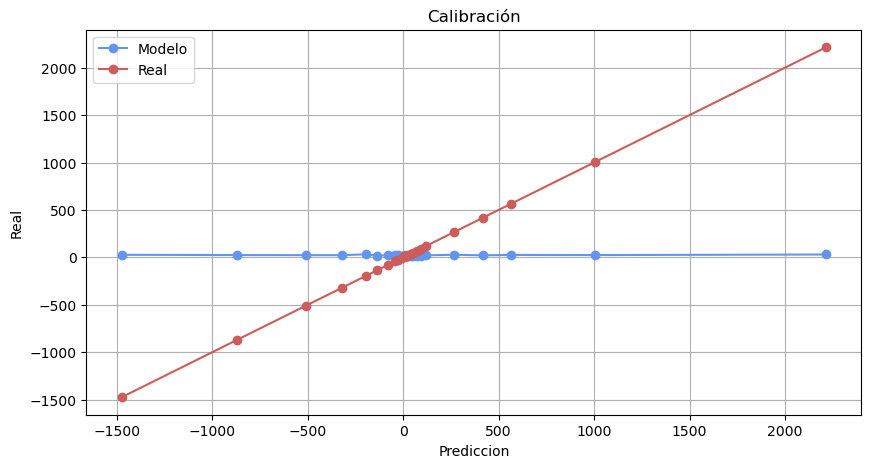

In [140]:
calibracion(predicciones_poly3, y_test, 25)

### Regularización Ridge

In [141]:
model = linear_model.Ridge().fit(X_poly_train, y_train)
predicciones_poly3_ridge = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly3_ridge)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly3_ridge)
print(f"MSE: {mse:,.4f}")

R² Score: 0.3009
MSE: 52.0902


#### Calibración

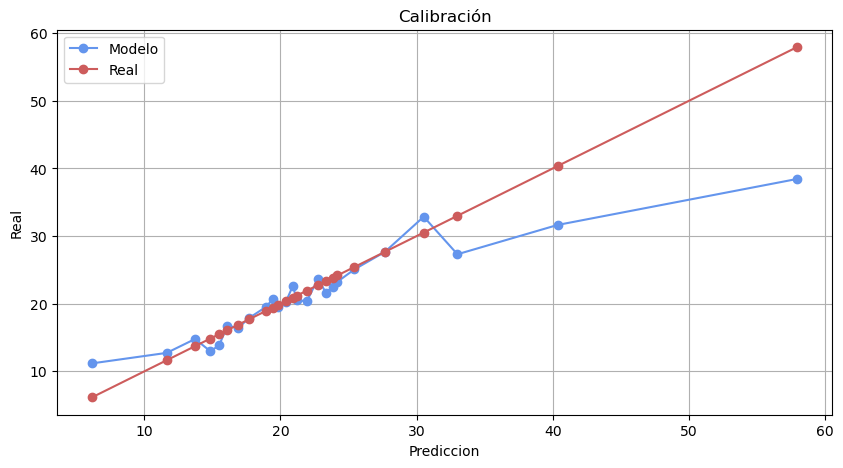

In [142]:
calibracion(predicciones_poly3_ridge, y_test, 25)

### Regularización Lasso

In [143]:
model = linear_model.Lasso().fit(X_poly_train, y_train)
predicciones_poly3_lasso = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly3_lasso)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly3_lasso)
print(f"MSE: {mse:,.4f}")

R² Score: 0.7038
MSE: 22.0694


#### Calibración

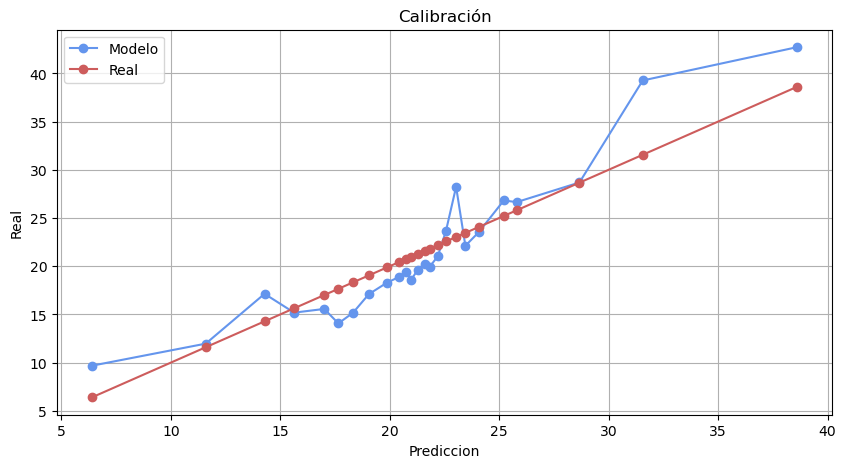

In [144]:
calibracion(predicciones_poly3_lasso, y_test, 25)

## Comparación modelos

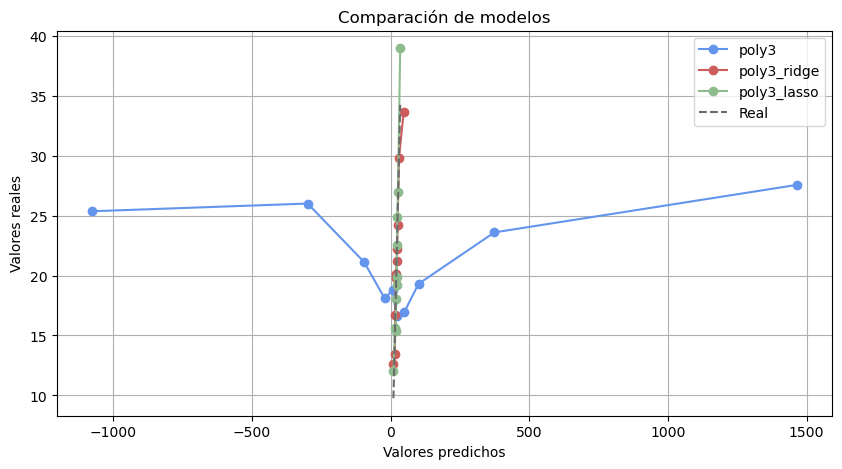

In [145]:
modelos = ['poly3', 'poly3_ridge', 'poly3_lasso']

comparacion(modelos, y_test)

## Grado 4

In [146]:
degree = 4

poly_features = PolynomialFeatures(degree=degree)
X_poly_train = poly_features.fit_transform(X_train_scaled)
X_poly_test = poly_features.fit_transform(X_test_scaled)

### Modelo Normal

In [147]:
model = linear_model.LinearRegression().fit(X_poly_train, y_train)
predicciones_poly4 = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly4)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly4)
print(f"MSE: {mse:,.4f}")

R² Score: -344.5662
MSE: 25,749.2062


#### Calibración

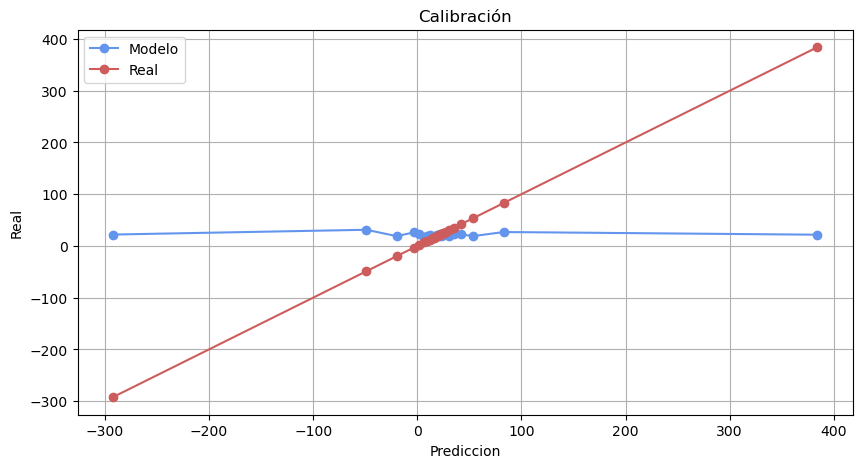

In [148]:
calibracion(predicciones_poly4, y_test, 25)

### Regularización Ridge

In [149]:
model = linear_model.Ridge().fit(X_poly_train, y_train)
predicciones_poly4_ridge = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly4_ridge)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly4_ridge)
print(f"MSE: {mse:,.4f}")

R² Score: -2.4967
MSE: 260.5523


#### Calibración

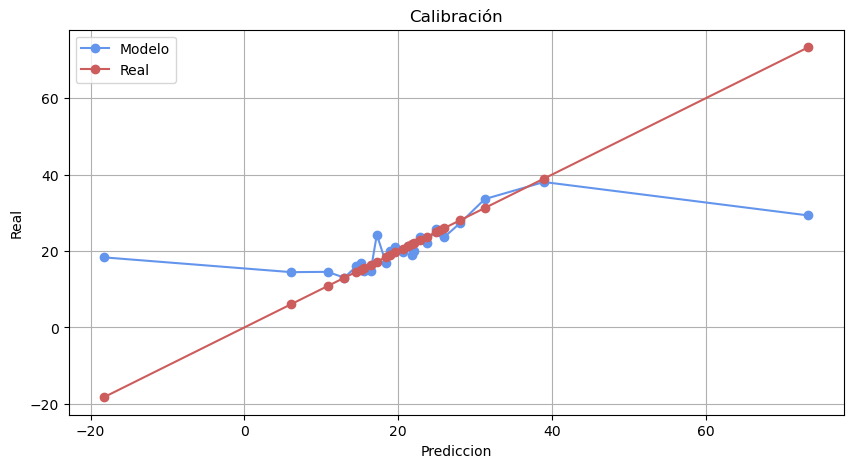

In [150]:
calibracion(predicciones_poly4_ridge, y_test, 25)

### Regularización Lasso

In [151]:
model = linear_model.Lasso().fit(X_poly_train, y_train)
predicciones_poly4_lasso = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly4_lasso)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly4_lasso)
print(f"MSE: {mse:,.4f}")

R² Score: 0.7323
MSE: 19.9443


#### Calibración

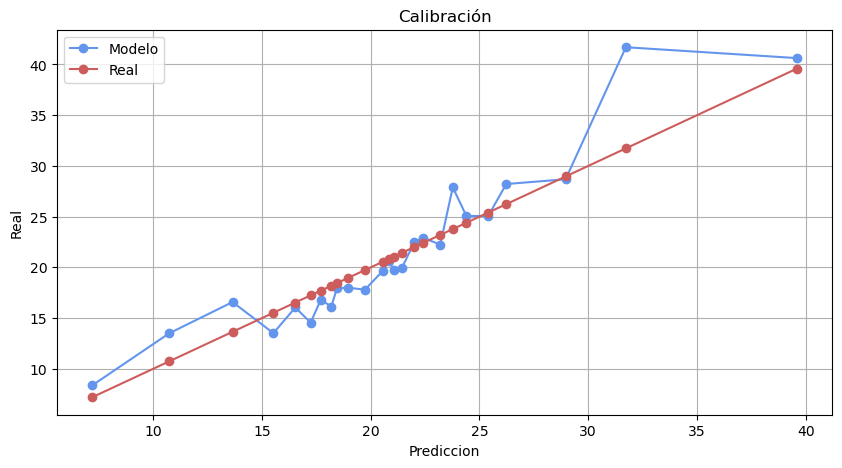

In [152]:
calibracion(predicciones_poly4_lasso, y_test, 25)

## Comparación modelos

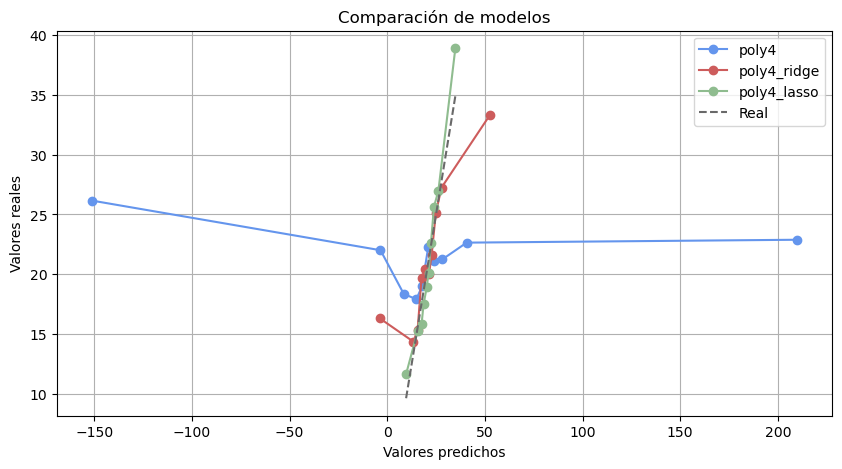

In [153]:
modelos = ['poly4', 'poly4_ridge', 'poly4_lasso']

comparacion(modelos, y_test)

# KNN

## Aproximación gráfica

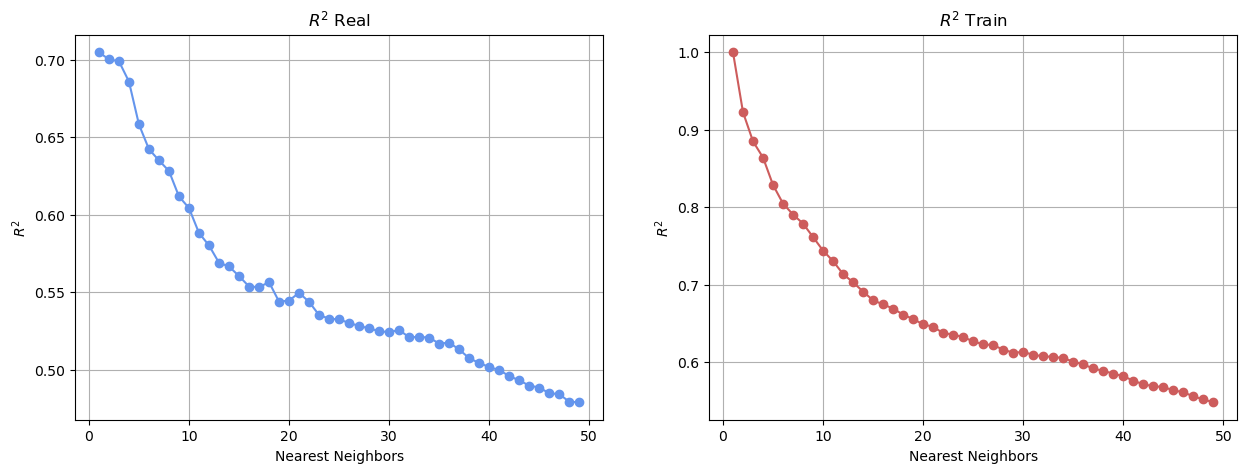

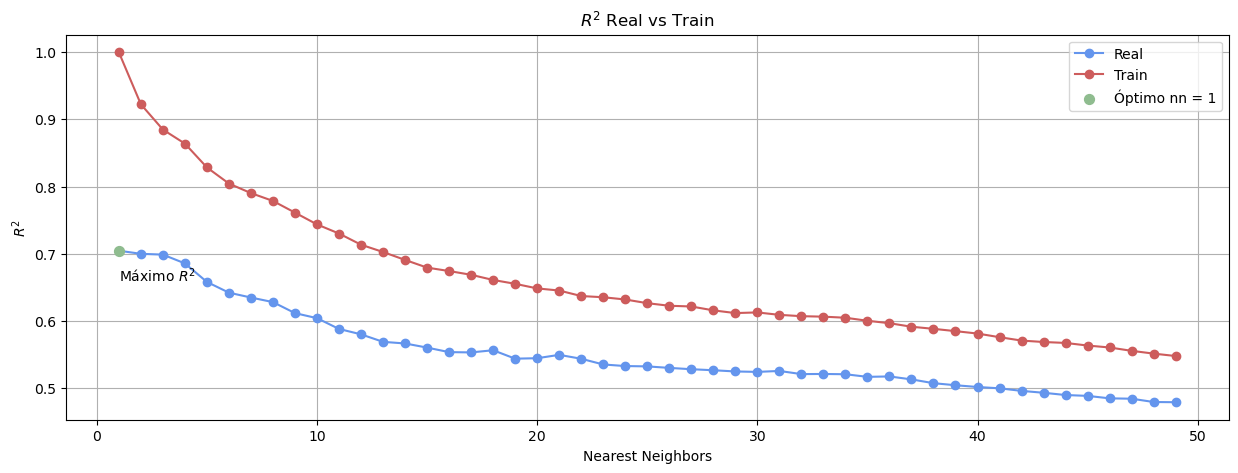

In [154]:
nn = []
r2 = []
r2_train = []
for i in range(1, 50):
    
    model = KNeighborsRegressor(n_neighbors=i).fit(X_train_scaled, y_train)
    predicciones = model.predict(X_test_scaled)

    r2.append(r2_score(y_true=y_test, y_pred=predicciones))
    nn.append(i)

    predicciones_train = model.predict(X_train_scaled)
    r2_train.append(r2_score(y_true=y_train, y_pred=predicciones_train))

resultados = pd.DataFrame({'r2': r2, 'nn': nn, 'r2_train': r2_train})

nn_opt = resultados[resultados.r2 == max(resultados.r2)].nn.values[0]

graficas_KNN(resultados, nn_opt)

## Prueba y error

In [155]:
model = KNeighborsRegressor(n_neighbors=nn_opt-1 if nn_opt > 1 else nn_opt).fit(X_train_scaled, y_train)
predicciones = model.predict(X_test_scaled)
nn_opt_nbr_minus = r2_score(y_true=y_test, y_pred=predicciones)

model = KNeighborsRegressor(n_neighbors=nn_opt).fit(X_train_scaled, y_train)
predicciones = model.predict(X_test_scaled)
nn_opt_nbr = r2_score(y_true=y_test, y_pred=predicciones)

model = KNeighborsRegressor(n_neighbors=nn_opt+1).fit(X_train_scaled, y_train)
predicciones = model.predict(X_test_scaled)
nn_opt_nbr_plus = r2_score(y_true=y_test, y_pred=predicciones)

print(f"R2 con {nn_opt-1 if nn_opt > 1 else nn_opt} neighbors: {nn_opt_nbr_minus:.4f} \nR2 con {nn_opt} neighbors: {nn_opt_nbr:.4f} \nR2 con {nn_opt+1} neighbors: {nn_opt_nbr_plus:.4f}")

R2 con 1 neighbors: 0.7047 
R2 con 1 neighbors: 0.7047 
R2 con 2 neighbors: 0.7001


# Conclusiones generales